#### use python 3.6 and tensorflow version 1.4.0 to run the code

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

/Users/avni/anaconda2/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/avni/anaconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### one-hot encoding function

In [2]:
def one_hot_encoding(total_sample, input_data, numbers):
    y = np.zeros((total_sample, numbers))
    for i in range(total_sample):
        position = input_data[i][0]
        y[i][position] = 1
    return y

#### Loading and normalizing testing and training data

In [3]:
train_x = np.load('exam2_train_x.npy')
train_y = np.load('exam2_train_y.npy')
print ("train y shape =", train_y.shape)
print ("train x shape =", train_x.shape)

train y shape = (1020,)
train x shape = (1020, 64, 64, 3)


In [4]:
Y_train = np.reshape(train_y, (train_y.shape[0],1))
train_y_one_hot = one_hot_encoding(1020, Y_train, 6)
train_y_one_hot.shape

(1020, 6)

In [5]:
test_x = np.load('exam2_test_x.npy')
test_y = np.load('exam2_test_y.npy')
print ("test y shape =", test_y.shape)
print ("test x shape =", test_x.shape)

test y shape = (180,)
test x shape = (180, 64, 64, 3)


In [6]:
Y_test = np.reshape(test_y, (test_y.shape[0],1))
test_y_one_hot = one_hot_encoding(180, Y_test, 6)
test_y_one_hot.shape

(180, 6)

In [7]:
train_x_norm = train_x/255 - 0.5
train_x_norm.shape

(1020, 64, 64, 3)

In [8]:
test_x_norm = test_x/255 - 0.5
test_x_norm.shape

(180, 64, 64, 3)

In [9]:
def placeholders(height, width, channels, classes): 
   
    x = tf.placeholder(tf.float32, [None, height, width, channels], name= 'x')
    y = tf.placeholder(tf.float32, [None, classes], name= 'y')
 #     mat = X_test.as_matrix()
    return x, y

In [10]:
def forward_propagation_with_dropout_xavier_initialization(X,keep_prob):

    print ("X shape =", X.shape)
    A1 = tf.layers.conv2d(X, filters = 8, kernel_size= (4,4), strides=(2, 2), padding='same' ,activation = tf.nn.relu,use_bias = True, kernel_initializer= tf.contrib.layers.xavier_initializer(seed=1) , bias_initializer=tf.zeros_initializer())
   
    print ("A1 shape =", A1.shape, ",channels= 8, kernel size = [4,4] , strides = [2,2], padding = same, activation= RELU, initialization = xavier")    
 
    P1 = tf.layers.max_pooling2d(A1, pool_size=(5,5), strides = (1, 1), padding='valid')
    
    print ("P1 shape =", P1.shape, ",pool size = [5,5], strides = [1,1], padding = valid")

    A2 = tf.layers.conv2d(P1, filters = 16, kernel_size= (4,4), strides= (2, 2), padding='valid' ,activation = tf.nn.relu, use_bias = True, kernel_initializer= tf.contrib.layers.xavier_initializer(seed=1) , bias_initializer=tf.zeros_initializer())

    print ("A2 shape =", A2.shape, ",channels = 16, kernel size = [4,4], strides [2,2], padding = valid, activation = RELU, initialization = xavier")

    P2 = tf.layers.average_pooling2d(A2, pool_size=(5,5),  strides = (1, 1), padding='valid')
    
    print ("P2 shape =", P2.shape, ",pool size = [5,5], strides = [1,1], padding = valid")
  
    F3 = tf.contrib.layers.flatten(P2)
    
    print ("F3 shape =", F3.shape)
  
    F4 = tf.contrib.layers.fully_connected(F3, 108, activation_fn= tf.nn.relu)
    
    print ("F4 shape =", F4.shape, ",activation = RELU")
    F4_dropout = tf.nn.dropout(F4, keep_prob)
    print ("keep probablility F4 = ", keep_prob)
    
    F5 = tf.contrib.layers.fully_connected(F4_dropout, 6, activation_fn= tf.nn.sigmoid)
#     F5_dropout = tf.nn.dropout(F5, keep_prob)
    print ("F5 shape =", F5.shape, ",activation = sigmoid")

    return F5

In [11]:
def compute_cost(F5, y_labels):
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=F5, labels= y_labels))
   
    return cost

In [12]:
def cnn_model(train_x, train_y, test_x, test_y, lr ,total_epochs,keep_prob): 
    
    tf.reset_default_graph()                         
    tf.set_random_seed(1) 
    np.random.seed(1)
    total_costs = []
    classes = train_y.shape[1]  
    samples = train_x.shape[0]
    height = train_x.shape[1]
    width = train_x.shape[2]
    channels = train_x.shape[3]     
    x, y = placeholders(height, width, channels, classes)
    
    #initialization , forward propagation and drop out in one function
    F5 = forward_propagation_with_dropout_xavier_initialization(x,  keep_prob)
  
    old_cost = compute_cost(F5, y) #computing old cost
     
    op = tf.train.AdamOptimizer(lr).minimize(old_cost) # optimizing using Adam Optimizer
       
    with tf.Session() as sess:     
        sess.run(tf.global_variables_initializer())
        
        for epoch in range(total_epochs):
            op_updated , new_cost = sess.run([op, old_cost], feed_dict={x:train_x, y:train_y})
            
            total_costs.append(new_cost) 
            
            if epoch % 100 == 0:
                print ("epoch =",epoch,"; new cost = " ,new_cost)                
  
        total_matches = tf.equal(tf.argmax(y, 1), tf.argmax(F5, 1))   
#      total_matches = tf.equal(tf.nn.softmax(y), tf.nn.softmax(F5))
        acc = tf.reduce_mean(tf.cast(total_matches, "float"))
        percent = tf.constant(100, dtype= tf.float32)
        acc_percent = tf.multiply(acc , percent)
    
        train_acc = acc_percent.eval({x: train_x, y: train_y})
        test_acc = acc_percent.eval({x: test_x, y: test_y})        
              
        return total_costs, train_acc, test_acc

In [13]:
total_costs, train_acc, test_acc = cnn_model(train_x_norm, train_y_one_hot, test_x_norm , test_y_one_hot, 0.01, 500, 0.9) 

X shape = (?, 64, 64, 3)
A1 shape = (?, 32, 32, 8) ,channels= 8, kernel size = [4,4] , strides = [2,2], padding = same, activation= RELU, initialization = xavier
P1 shape = (?, 28, 28, 8) ,pool size = [5,5], strides = [1,1], padding = valid
A2 shape = (?, 13, 13, 16) ,channels = 16, kernel size = [4,4], strides [2,2], padding = valid, activation = RELU, initialization = xavier
P2 shape = (?, 9, 9, 16) ,pool size = [5,5], strides = [1,1], padding = valid
F3 shape = (?, 1296)
F4 shape = (?, 108) ,activation = RELU
keep probablility F4 =  0.9
F5 shape = (?, 6) ,activation = sigmoid
epoch = 0 ; new cost =  1.7919747
epoch = 100 ; new cost =  1.1001912
epoch = 200 ; new cost =  1.0600066
epoch = 300 ; new cost =  1.0519183
epoch = 400 ; new cost =  1.0497301


training data accuracy = 99.5098  %
testing data accuracy = 96.666664  %


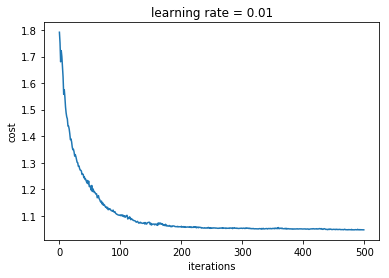

In [14]:
print("training data accuracy =", train_acc, " %")
print("testing data accuracy =", test_acc, " %")
"Plotting cost vs iterations graph"
plt.plot(total_costs)       
plt.xlabel("iterations")
plt.ylabel("cost")
plt.title("learning rate = 0.01")
plt.show()

#### Training Data Accuracy = 99.5098 %
#### Testing Data Accuracy = 96.67 % 